# Importing libraries
We rely heavily on `pandas` and `scikit-learn` libraries.

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import make_scorer, r2_score, explained_variance_score, mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

# Loading the data
The `pandas` library allows to read directly `pickle` files.

In [2]:
pickle_dir = 'pickles'
X_train = pd.read_pickle(os.path.join(pickle_dir, 'X_train.pkl'))
X_test = pd.read_pickle(os.path.join(pickle_dir, 'X_test.pkl'))
y_train = pd.read_pickle(os.path.join(pickle_dir, 'y_train.pkl'))
y_test = pd.read_pickle(os.path.join(pickle_dir, 'y_test.pkl'))

# Preparing nested cross-validation
Nested cross-validation is nothing but a two-level nested loop on the indices of the data frame. This loop functionality is provided by the `KFold` class of `sklearn`. We specify the number of splits `n_splits`, and if we want indices to be randomized before splitting (`shuffle`). Furthermore, we enforce reproducility of the results by specifying the random seed for random number generations.

In [3]:
seed = 1
inner_cv = KFold(n_splits=3, shuffle=True, random_state=seed)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=seed)

# Defining models
We want to apply a linear regression. Linear regression needs features to be scaled, in order to avoid coefficients of very different order of magnitude. Feature scaling *is* machine learning, since feature scales have to be *learned*. We thus build a machine learning pipeline where *(i)* continuous features are selected and the normalizations are learned from the training set, and *(ii)* coefficients of the linear regression are learned. The prediction phase also has two steps: rescaling the testing set with the learned normalizations, and then predict with the learned linear model. All this can be fully included in a `sklearn pipeline`. First, we need to build a transformer that merely select columns (continuous to be rescaled, or discrete). 

In [4]:
class MySelector(BaseEstimator, TransformerMixin):

    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        return x[self.key]

This transformer allows to select continuous features. This distinction between features is performed as follows:

In [5]:
where_continuous = X_train.dtypes == 'float64'
continuous_features = X_train.dtypes[where_continuous].index.tolist()
other_features = X_train.dtypes[~where_continuous].index.tolist()

The linear regression pipeline begins with the `union` of `other_features` and `continous_features`, the former being unchanged, the latter being rescaled. Once the data are preprocessed, the linear regression can be learned. The `make_pipeline` and `make_union` factories allow build this pipeline.

In [6]:
lr = make_pipeline(
    make_union(
        MySelector(other_features),          # select discrete features
        make_pipeline(
            MySelector(continuous_features), # select continous features
            StandardScaler()                 # normalize continuous features
        )
    ), # end of union: discrete features are concatenated with scaled continous features
    LinearRegression() # final step: the linear regression is learned
)

In order to assess the influence of outliers, we propose a variant of linear regression, namely Huber regression. It basically uses squared loss for points close to the prediction and absolute loss for outliers. Unlike linear regression, Huber regression does not natively manages multiple outputs. We overcome this difficulty with the `MultipleOutputRegressor` decorator of `scikit-learn`.

In [7]:
hr = make_pipeline(
    make_union(
        MySelector(other_features),          # select discrete features
        make_pipeline(
            MySelector(continuous_features), # select continous features
            StandardScaler()                 # normalize continuous features
        )
    ), # end of union: discrete features are concatenated with scaled continous features
    MultiOutputRegressor(HuberRegressor()) # final step: the linear regression is learned
)

Finally, we instanciate a random forest model, that is insensitive to feature scaling. We also fix the seed of randoom processes occuring inside random forest (bootstrap and feature selection). Note that even if the random forest algorithm naturally deals with multiple outputs, [it can be shown](http://scikit-learn.org/stable/auto_examples/ensemble/plot_random_forest_regression_multioutput.html) that it is worth training one instance of the algorithm per output.

In [8]:
rf = MultiOutputRegressor(RandomForestRegressor(random_state=seed))

# Defining a metric based on multiple outputs
Linear regression and random forest naturally deal with multiple outputs, so that we can have a 2-dimensional target made of `casual` and `registered`. However, we want to evaluate the performances on the `count` variable, which is obtained by remember the log transformation in feature engineering)

$$count = \exp(casual) + \exp(registered) - 2.$$

We thus create a `to_count` function for converting raw outputs back into the original `count` variable.

In [9]:
def to_count(y):
    return np.exp(y).sum(axis=1).round() - 2

We then build a scoring function `count_score`, that simply combines the two outputs together before evaluating. We also enable the use of different metrics, such as $R^2$-score, explaind variance ratio, mean absolute error and mean squared error.

In [10]:
def count_score(y_true, y_pred, **kwargs):
    y_count = to_count(y_true)
    y_pred_count = to_count(y_pred)
    metric = kwargs['metric']
    if (metric == 'r2'):
        return r2_score(y_count, y_pred_count)
    elif (metric == 'explained_variance'):
        return explained_variance_score(y_count, y_pred_count)
    elif (metric == 'mae'):
        return mean_absolute_error(y_count, y_pred_count)
    elif (metric == 'mse'):
        return mean_squared_error(y_count, y_pred_count)
    elif (metric == 'msle'):
        return mean_squared_log_error(y_count, y_pred_count)
    else:
        return r2_score(y_count, y_pred_count)

The `make_scorer` factory of `sklearn` allows to directly use our performance metric within nested cross-validations. We choose the mean squared log error, since the distribution is highly skewed (see log transformation in feature engineering) and it penalizes more under estimates than over estimates. This makes sense for a bike rental application.

In [11]:
my_scorer = make_scorer(count_score, metric='msle')

# Cross-validation: evaluating simple models
Linear regressors have no parameters, so that we can simply evaluate them by cross-validation on the testing set.

In [12]:
scores_lr = cross_val_score(lr, X_train, y_train, cv=outer_cv, scoring=my_scorer)
scores_hr = cross_val_score(hr, X_train, y_train, cv=outer_cv, scoring=my_scorer)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


# Nested cross-validation: optimizing and evaluating complex models
Random forest has several parameters to optimize, especially the number of trees `n_estimators` in the ensemble, and the maximum number of features `max_features` used in feature sampling at each node.

In [13]:
params = {
    'estimator__n_estimators': [10, 100], # estimator__ is the syntax to access members of MultipleOutputRegreesor
    'estimator__max_features': [0.33, 0.66, 1.0]
}

We build the `rfo` estimator (optimized random forest), that is nothing but a grid search estimator (inner loop) evaluated by cross-validation (outer loop). Note that be default, the grid search estimator ends with a refit step, fitting the best estimator on the whole training set.

In [14]:
rfo = GridSearchCV(rf, params, cv=inner_cv, scoring=my_scorer, return_train_score=False, verbose=1)
scores_rf = cross_val_score(rfo, X_train, y_train, cv=outer_cv, scoring=my_scorer, n_jobs=3, verbose=1)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   22.4s finished
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   22.6s finished
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   22.8s finished
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   23.0s finished


Our three models have been evaluated on the same folds of cross-validation, with an additional optimization intermediate step for random forest. We can compare their performances on year 2011.

In [15]:
print(scores_lr)
print(scores_hr)
print(scores_rf)

[0.33758628 0.31265446 0.3358173 ]
[0.35623204 0.32663621 0.35086187]
[0.14632159 0.12577189 0.12697207]


Linear regression seems to already captures a large part of the target variance. Random forest is unambiguously performing best at predicting the `count` target.

# Fitting the training set
Now that we have evaluated our models on the year 2011, we prepare the final evaluation on year 2012 by fitting our models to the whole training set. The optimization step of random forest requires a single cross-validation step again.

In [16]:
lr.fit(X_train, y_train)
hr.fit(X_train, y_train)
rfo.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   21.2s finished


GridSearchCV(cv=KFold(n_splits=3, random_state=1, shuffle=True),
       error_score='raise',
       estimator=MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False),
           n_jobs=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'estimator__n_estimators': [10, 100], 'estimator__max_features': [0.33, 0.66, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=make_scorer(count_score, metric=msle), verbose=1)

It is informative to look at the results of the cross-validated optimization, to identify best parameters.

In [17]:
pd.DataFrame(rfo.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__max_features,param_estimator__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.193095,0.080493,0.013756,0.006085,0.33,10,"{'estimator__max_features': 0.33, 'estimator__...",0.146322,0.125772,0.126972,0.133024,0.009418,1
1,1.338712,0.130584,0.067667,0.008663,0.33,100,"{'estimator__max_features': 0.33, 'estimator__...",0.127914,0.116179,0.115599,0.119899,0.005674,4
2,0.223409,0.026012,0.011898,0.005944,0.66,10,"{'estimator__max_features': 0.66, 'estimator__...",0.134438,0.122334,0.120434,0.125737,0.006203,2
3,2.087747,0.260589,0.055289,0.000158,0.66,100,"{'estimator__max_features': 0.66, 'estimator__...",0.117196,0.107538,0.107901,0.110880,0.004470,6
4,0.266322,0.001122,0.008393,0.000152,1,10,"{'estimator__max_features': 1.0, 'estimator__n...",0.123755,0.123921,0.123235,0.123637,0.000292,3
5,2.683381,0.053261,0.099038,0.032959,1,100,"{'estimator__max_features': 1.0, 'estimator__n...",0.118807,0.108942,0.115881,0.114544,0.004137,5


# Evaluation on the testing set
Now that our models are fully learned on the training set, we simply have to collect predictions on the testing set.

In [18]:
names=[]
scores = []
predictions = dict()
for name, clf in {'linear':lr, 'huber': hr, 'random_forest':rfo}.items():
    y_pred = clf.predict(X_test)
    score = count_score(y_test, y_pred, metric='msle')
    predictions[name] = pd.DataFrame(data=y_pred, index=y_test.index, columns=['casual', 'registered'])
    names.append(name)
    scores.append(score)

Scores are made more visible within a `pandas` data frame.

In [19]:
pd.DataFrame(scores, index=names, columns=['score'])

,score
linear,0.386547
huber,0.373951
random_forest,0.229806


In comparison with our evaluation on year 2011, there is a large decrease in performances. This is a strong indication of concept drift: years 2011 and 2012 are not identically distributed.

# Examination of the results
Still, we can get more insight in our models. Coefficients of the linear regression are:

In [20]:
coefs = np.abs(lr.named_steps['linearregression'].coef_)
coefs_casual = pd.DataFrame(coefs[0], index=X_train.columns, columns=['coefs']).sort_values('coefs')
coefs_registered = pd.DataFrame(coefs[1], index=X_train.columns, columns=['coefs']).sort_values('coefs')

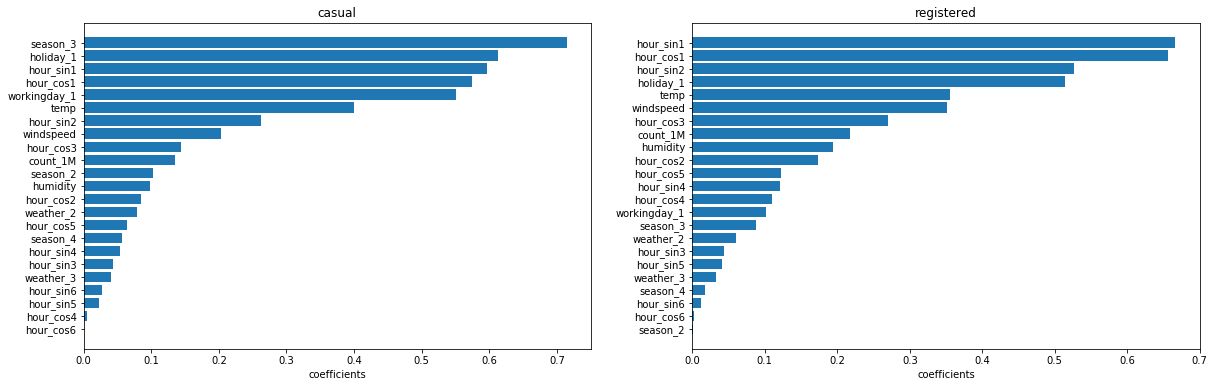

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))
ax[0].barh(coefs_casual.index, coefs_casual['coefs'])
ax[1].barh(coefs_registered.index, coefs_registered['coefs'])
ax[0].set_title('casual')
ax[1].set_title('registered')
ax[0].set_xlabel('coefficients')
ax[1].set_xlabel('coefficients')
plt.show()

As for Huber regression, we obtain:

In [22]:
coefs_casual = np.abs(hr.named_steps['multioutputregressor'].estimators_[0].coef_)
coefs_registered = np.abs(hr.named_steps['multioutputregressor'].estimators_[1].coef_)
coefs_casual = pd.DataFrame(coefs_casual, index=X_train.columns, columns=['coefs']).sort_values('coefs')
coefs_registered = pd.DataFrame(coefs[1], index=X_train.columns, columns=['coefs']).sort_values('coefs')

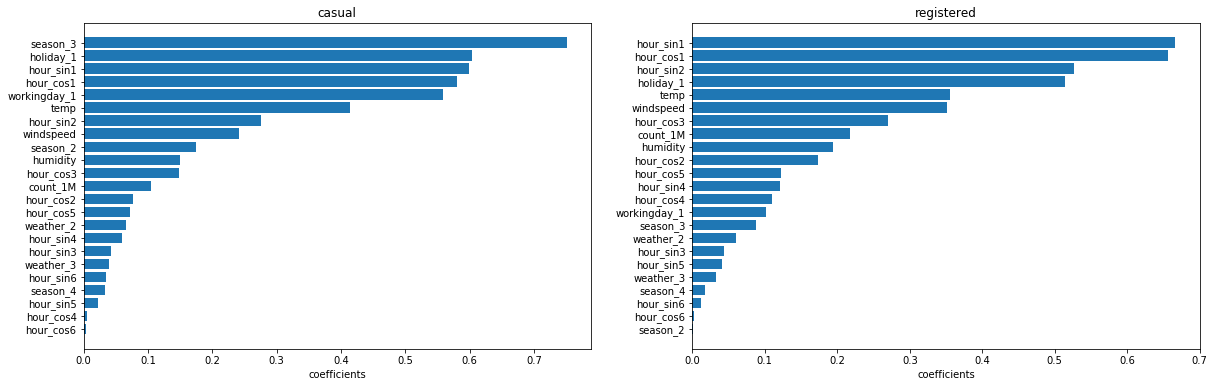

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))
ax[0].barh(coefs_casual.index, coefs_casual['coefs'])
ax[1].barh(coefs_registered.index, coefs_registered['coefs'])
ax[0].set_title('casual')
ax[1].set_title('registered')
ax[0].set_xlabel('coefficients')
ax[1].set_xlabel('coefficients')
plt.show()

It seems that `casual` counts are most easily predicted by weather and holiday variables, while `registered` estimators are strongly influenced by day hour. This does not break intuition since it is expected that `registered` users are mainly workers with fixed and regular working hours, while `casual` users are more prone to take advantage of meteorological conditions during holidays. 

Let us see if this is confirmed by random forest features importances.

In [24]:
features = X_train.columns
importances = dict(zip(['casual', 'registered'], [rfo.best_estimator_.estimators_[i].feature_importances_ for i in [0,1]]))
fi_casual = pd.DataFrame(importances['casual'], index=features, columns=['importance']).sort_values('importance')
fi_registered = pd.DataFrame(importances['registered'], index=features, columns=['importance']).sort_values('importance')

Text(0.5,1,'registered')

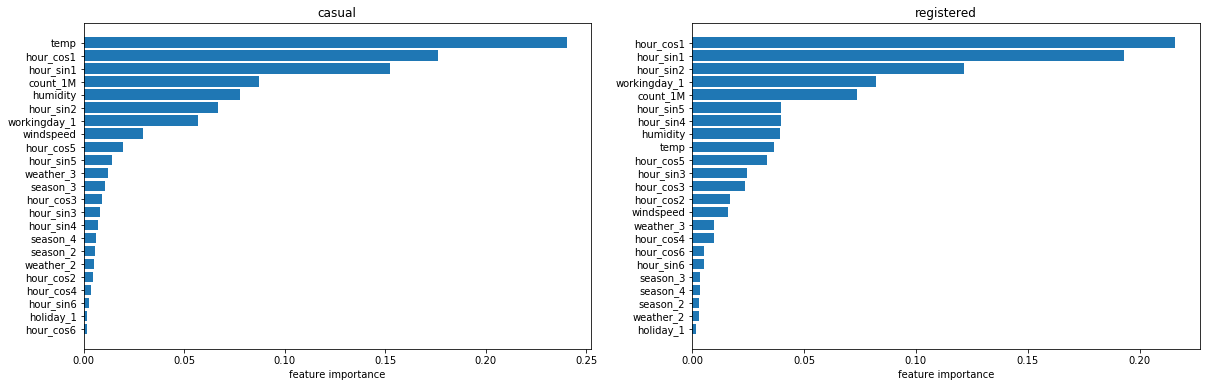

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))
ax[0].barh(fi_casual.index, fi_casual['importance'])
ax[1].barh(fi_registered.index, fi_registered['importance'])
ax[0].set_xlabel('feature importance')
ax[1].set_xlabel('feature importance')
ax[0].set_title('casual')
ax[1].set_title('registered')

Again, weather variables influence the most `casual` users, while the time of day and the estimation of the total number of registered users `count_1M` are strongly influencial variables for `registered` users.

Now we investigate the residuals of our predictions.

In [26]:
residuals = pd.DataFrame({'linear': to_count(y_test) - to_count(predictions['linear']), 
                          'huber': to_count(y_test) - to_count(predictions['huber']), 
                          'random_forest':to_count(y_test) - to_count(predictions['random_forest'])})

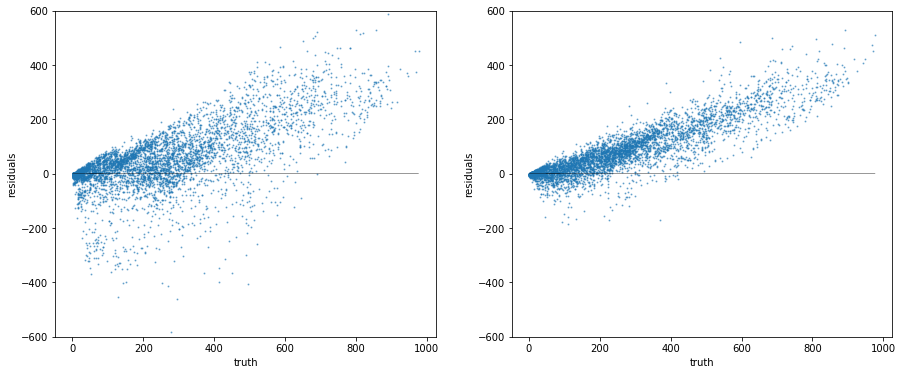

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].scatter(to_count(y_test), residuals['huber'], s=1, alpha=0.5)
ax[0].plot(to_count(y_test), [0]*len(y_test.index), c='black', linewidth=0.2)
ax[1].scatter(to_count(y_test), residuals['random_forest'], s=1, alpha=0.5)
ax[1].plot(to_count(y_test), [0]*len(y_test.index), c='black', linewidth=0.2)
ax[0].set_xlabel('truth')
ax[1].set_xlabel('truth')
ax[0].set_ylabel('residuals')
ax[1].set_ylabel('residuals')
ax[0].set_ylim((-600, 600))
ax[1].set_ylim((-600, 600))
plt.show()

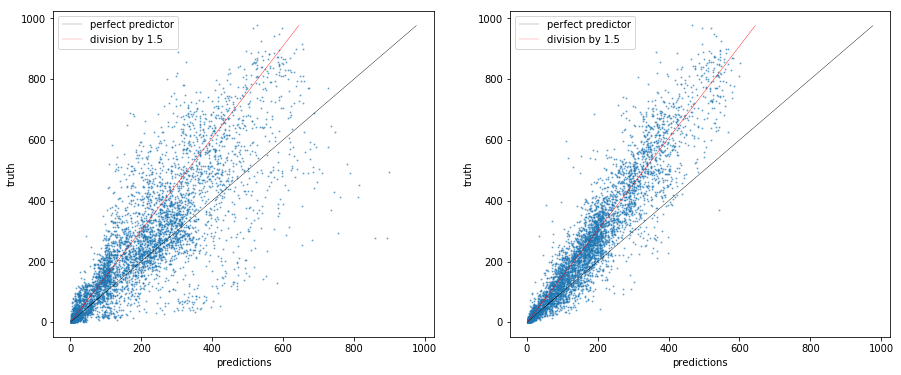

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].scatter(to_count(predictions['huber']), to_count(y_test), s=1, alpha=0.5)
ax[0].plot(to_count(y_test), to_count(y_test), c='black', linewidth=0.2, label='perfect predictor')
ax[0].plot(to_count(y_test)*0.66, to_count(y_test), c='r', linewidth=0.2, label='division by 1.5')
ax[1].scatter(to_count(predictions['random_forest']), to_count(y_test), s=1, alpha=0.5)
ax[1].plot(to_count(y_test), to_count(y_test), c='black', linewidth=0.2, label='perfect predictor')
ax[1].plot(to_count(y_test)*0.66, to_count(y_test), c='r', linewidth=0.2, label='division by 1.5')
ax[0].set_xlabel('predictions')
ax[1].set_xlabel('predictions')
ax[0].set_ylabel('truth')
ax[1].set_ylabel('truth')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.show()

It appears clearly that our predictions largely underestimate true values of counts, by around $30\%$. This means that there was a $50\%$ increase of the number locations in the testing set with respect to the training set. Combined with the discrepancy in performances between years 2011 and 2012, a concept drift appears clearly between the two years. The intuition is that the number of users has drastically increased between the two years, probably because of a better service and/or communication.

By using year 2011 for training and 2012 for evaluating, we obviously obtain worse performances than if we would have started with a standard random train/test split (exercise: do it). However in much the same way we have overfitted year 2011, this method would have overfitted years 2011-2012, and any conclusion about performances would have been patently incorrect, even if evaluated on the testing set.

The only purpose of evaluation (and hence of the testing set), is to simulate reality. Had we mixed years 2011 and 2012, we would have faced a logical impossibility to conclude about performances in the future, given that the target is evolving in time. The advantage of our method is that it clearly identifies concept drift, and gives a realistic estimation of *how much* our algorithm would be incorrect in the near future.

Static algorithms are obviously not fully appropriate in such evolving data streams, and adaptive machine learning solutions should be considered.